In [1]:
##run this first to install package, then delete
conda install webdriver-manager selenium pandas

SyntaxError: invalid syntax (1152895909.py, line 2)

In [2]:
# import libraries
import time 
import json
import random
import requests
import pandas as pd 
from selenium import webdriver 
from selenium.webdriver import Chrome 
from selenium.webdriver.chrome.service import Service 
from selenium.webdriver.common.by import By 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.ui import WebDriverWait

Run this block below as is

In [3]:
# start by defining the options 
options = webdriver.ChromeOptions() 
options.headless = True # it's more scalable to work in headless mode 
# normally, selenium waits for all resources to download 
# we don't need it as the page also populated with the running javascript code. 
options.page_load_strategy = 'none' 
# this returns the path web driver downloaded 
chrome_path = ChromeDriverManager().install() 
chrome_service = Service(chrome_path) 
# pass the defined options and service objects to initialize the web driver 
driver = Chrome(options=options, service=chrome_service) 
driver.implicitly_wait(5)

/var/folders/vv/c90tdsjn63g4803dfq4s7w4m0000gn/T/ipykernel_77037/210964506.py:3: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True # it's more scalable to work in headless mode


This stores a list of listing urls based on a desired quantity (each listing page contains 120 listings). I'm keeping the number low for now, just for efficiency but we'll have to discuss how many individual listings we want to try and scrape. 

In [4]:
url_list = []
page = 0
num_pages = 77

# get urls
for x in range(num_pages):
    page += 1 
    url_list.append("https://losangeles.craigslist.org/search/apa?query=los%20angeles#search=1~list~{}~0".format(page))

For each page of listings, we need to grab the urls for each of the 120 individual listings.

In [5]:
listings = []

for url in url_list:
    # create WebElement of Listings Page
    driver.get(url)
    
    driver.implicitly_wait(5)
    
    # find the section the listings are located in
    content = driver.find_element(By.CSS_SELECTOR, "div[class*='cl-results-page'")
    
    # find the section where the link to the property page is located for each 120 listings
    for element in content.find_elements(By.TAG_NAME, "li")[1:]:
        try:
            listings.append(element.find_elements(By.CSS_SELECTOR, "div[class*='result-node-wide']>a")[0].get_attribute("href"))
            
        except (StaleElementReferenceException, NoSuchElementException) as e:
            listings.append('NA')
    
            
    # add delay (not sure about actually length of time delays necessary)
    time.sleep(random.randint(1, 3))
    
listingsDf = pd.DataFrame(listings)
listingsDf.rename(columns = {0:"urls"}, inplace = True)
# limiting size for testing
listingsDf = listingsDf
# check DF
listingsDf.head()

,urls
0,https://losangeles.craigslist.org/wst/apa/d/lo...
1,https://losangeles.craigslist.org/lac/apa/d/lo...
2,https://losangeles.craigslist.org/lac/apa/d/lo...
3,https://losangeles.craigslist.org/lac/apa/d/lo...
4,https://losangeles.craigslist.org/lac/apa/d/lo...


Now we will scrape each webpage from the list of urls. This is where most of our development and discussion needs to occur. I've placed a temporary simple test in there for now. 

In [5]:
#listingsDf[listingsDf.urls == 'NA']

In [6]:
listingsDf_trim = listingsDf[:1000]

In [8]:
description = []
latitude = []
longitude = []
title = []
ignored_exceptions=(NoSuchElementException,StaleElementReferenceException,)


for url in listingsDf_trim['urls']:
    # create WebElement of listing URL
    driver.get(url)
    
    driver.maximize_window() # For maximizing window
    driver.implicitly_wait(5) # gives an implicit wait for 20 seconds
   
    # grab description of listing and add to list
    try:
        #description
        description.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingbody"))).text)
        
        #lat
        latitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        latitude_value = latitude_element.get_attribute("data-latitude")
        latitude.append(latitude_value)
                
        #long
        longitude_element = WebDriverWait(driver, 5, ignored_exceptions=ignored_exceptions).until(
                        expected_conditions.presence_of_element_located((By.ID, "map"))
                        )
        longitude_value = longitude_element.get_attribute("data-longitude")
        longitude.append(longitude_value)
        
        #price
        title.append(WebDriverWait(driver, 5,ignored_exceptions=ignored_exceptions)\
                        .until(expected_conditions.presence_of_element_located((By.ID, "postingtitle"))).text)
        
        
    except (StaleElementReferenceException, NoSuchElementException, TimeoutException) as e:
        description.append('NA')
        latitude.append('NA')
        longitude.append('NA')
    
    time.sleep(random.randint(1, 3))
    
listingsDf_trim['description'] = description
listingsDf_trim['lat'] = latitude
listingsDf_trim['long'] = longitude

WebDriverException: Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: headless chrome=114.0.5735.106)
Stacktrace:
0   chromedriver                        0x000000010541b6b8 chromedriver + 4937400
1   chromedriver                        0x0000000105412b73 chromedriver + 4901747
2   chromedriver                        0x0000000104fd0616 chromedriver + 435734
3   chromedriver                        0x0000000104fb6bc1 chromedriver + 330689
4   chromedriver                        0x0000000104fb6923 chromedriver + 330019
5   chromedriver                        0x0000000104fd2262 chromedriver + 442978
6   chromedriver                        0x000000010505256e chromedriver + 968046
7   chromedriver                        0x0000000105037de3 chromedriver + 859619
8   chromedriver                        0x0000000105005d7f chromedriver + 654719
9   chromedriver                        0x00000001050070de chromedriver + 659678
10  chromedriver                        0x00000001053d72ad chromedriver + 4657837
11  chromedriver                        0x00000001053dc130 chromedriver + 4677936
12  chromedriver                        0x00000001053e2def chromedriver + 4705775
13  chromedriver                        0x00000001053dd05a chromedriver + 4681818
14  chromedriver                        0x00000001053af92c chromedriver + 4495660
15  chromedriver                        0x00000001053fa838 chromedriver + 4802616
16  chromedriver                        0x00000001053fa9b7 chromedriver + 4802999
17  chromedriver                        0x000000010540b99f chromedriver + 4872607
18  libsystem_pthread.dylib             0x00007ff804841259 _pthread_start + 125
19  libsystem_pthread.dylib             0x00007ff80483cc7b thread_start + 15


In [ ]:
listingsDf_trim

In [ ]:
listingsDf_trim_1000 = listingsDf_trim

In [ ]:
listingsDf_trim_100 = listingsDf[:100]

In [11]:
import re

def remove_and_clean(text):
    text = re.sub(("\n"), " ", text)
    text = text.lower()
    return text

listingsDf_trim['description'] = listingsDf_trim['description'].apply(remove_and_clean)

/var/folders/vv/c90tdsjn63g4803dfq4s7w4m0000gn/T/ipykernel_68608/568058012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listingsDf_trim['description'] = listingsDf_trim['description'].apply(remove_and_clean)


In [12]:
import geopandas as gpd

parks = gpd.read_file('county_parks.geojson')
parks

,OBJECTID,UNIT_ID,LMS_ID,PARK_NAME,PARK_LBL,ACCESS_TYP,RPT_ACRES,GIS_ACRES,AGNCY_NAME,AGNCY_LEV,...,CENTER_LON,ADDRESS,CITY,ZIP,HOURS,PHONES,IS_COUNTY,Shape__Area,Shape__Length,geometry
0,1,30.0,23603.0,El Barrio Park,El Barrio Park,Open Access,2.093000,2.092992,"Claremont, City of",City,...,-117.704423,400 Claremont Blvd,Claremont,91711,NaN,NaN,No,9.117036e+04,1451.547906,"POLYGON ((-117.70383 34.09747, -117.70421 34.0..."
1,2,56.0,NaN,El Dorado Park,El Dorado Park,Open Access,5.144000,5.143217,"Lancaster, City of",City,...,-118.122109,44501 5th St E,Lancaster,93535,NaN,NaN,No,2.240376e+05,2192.277128,"POLYGON ((-118.12252 34.69275, -118.12252 34.6..."
2,3,62.0,3000015.0,Atlantic Avenue Park,Atlantic Avenue Park,Open Access,1.960000,1.959610,"Los Angeles, County of",County,...,-118.155201,570 S. Atlantic Blvd.,Los Angeles,90022,March 1st to October 31st<br>\nOperating Hours...,General/Aquatics: (323) 260-2341; Reservations...,Yes,8.536029e+04,1139.269960,"POLYGON ((-118.15541 34.02582, -118.15540 34.0..."
3,4,72.0,22715.0,El Escorpion Park,El Escorpion Park,Open Access,66.914000,66.338029,"Los Angeles, City of",City,...,-118.664169,6801 Sunset Ridge Ct,West Hills,91307,NaN,(818) 883-6641,No,2.889673e+06,7761.831975,"POLYGON ((-118.66713 34.19881, -118.66714 34.1..."
4,5,78.0,22860.0,El Marino Park/ El Marino Elementary,El Marino Park Elementary/El Marino Park,Open Access,3.200000,1.650439,"Culver City, City of",City,...,-118.399233,11450 Port Rd,Culver City,90230,NaN,NaN,No,7.189283e+04,1215.415276,"POLYGON ((-118.39909 33.99221, -118.39910 33.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,3009,6970.0,3000052.0,Eaton Canyon Natural Area and Nature Center,Eaton Canyon Park and Nature Ctr.,Open Access,219.087769,219.087769,"Los Angeles, County of",County,...,-118.096038,1750 N. Altadena Dr.,Pasadena,91001,March 1st to October 31st<br>\nOperating Hours...,General: (626) 398-5420,Yes,9.543472e+06,46367.511401,"MULTIPOLYGON (((-118.09584 34.18610, -118.0960..."
3008,3010,6229.0,3000074.0,"Earvin ""Magic"" Johnson Recreation Area",Earvin 'Magic' Johnson Rec. Area,Open Access,120.660000,120.660543,"Los Angeles, County of",County,...,-118.260350,905 E. El Segundo Blvd.,Los Angeles,90059,Operating Hours<br>\nMonday – Sunday<br>\n6:30...,General: (323) 942-8457; Reservations: (800) 4...,Yes,5.255955e+06,15742.071556,"MULTIPOLYGON (((-118.25615 33.91651, -118.2564..."
3009,3011,100023.0,3000071.0,Hollywood Bowl,Hollywood Bowl,Open Access,77.430000,77.428979,"Los Angeles, County of",County,...,-118.339429,2301 N. Highland Ave.,Los Angeles,90068,<Null>,General: (323) 850-2060,Yes,3.372794e+06,14811.941036,"MULTIPOLYGON (((-118.33613 34.10801, -118.3362..."
3010,3012,7277.0,3000064.0,William S. Hart Regional Park,William S. Hart Regional Park,Open Access,155.869048,155.869048,"Santa Clarita, City of",City,...,-118.526456,24151 N. Newhall Ave.,Newhall,91321,March 1st to October 31st\nOperating Hours\nTu...,General: (661) 259-1750,Yes,6.789656e+06,14398.274986,"MULTIPOLYGON (((-118.52545 34.37595, -118.5252..."


In [258]:
park_terms = ['hike', 
                'hiking',
                'trail', 
                'trails', 
                'community park',
                'community parks', 
                'local park',
                'local parks',
                 'parks nearby',
                'public parks',
                'public park',
                'hollywood sign',
                'echo park lake',
                'park access',
                'parks',
              'recreational parks'
                 ]

In [275]:
excluded = ['highland park',
           'hancock park',
           'echo park and silverlake',
            'silverlake and echo park',
           'rancho park',
           'macarthur park station',
           'south park',
           'rooftop park',
           'small dog parks']

In [276]:
sneaky_neighborhoods = ['highland park',
                       'echo park',
                       'hancock park',
                       'south park',
                       'elysian park']

make every listing that has a park name from the parks data file "true" unless its one of the excluded parks ie highland park (728 false)

In [277]:
#listingsDf_trim['park_TF'] = listingsDf_trim['description'].apply(
    #lambda x: any(substring in x for substring in parks['PARK_NAME'].str.lower()) and not any(substring in x for substring in excluded))

maybe this does all the things at once?

In [280]:
listingsDf_trim['park_TF'] = listingsDf_trim['description'].apply(
    lambda x: any(substring in x for substring in parks['PARK_NAME'].str.lower()) and not any(substring in x for substring in excluded)or any(substring in x for substring in park_terms))

add true to all the key park words (things like trails etc.) 

In [281]:
#listingsDf_trim['park_TF'] = listingsDf_trim['description'].apply(
    #lambda x: any(substring in x for substring in park_terms))

In [282]:
#listingsDf_trim['park_TF'] = listingsDf_trim['description'].apply(
    #lambda x: any(substring in x for substring in parks['PARK_NAME'].str.lower()) or any(substring in x for substring in park_terms))


<div id="map" class="viewposting leaflet-container leaflet-retina leaflet-fade-anim leaflet-grab leaflet-touch-drag" data-latitude="33.959712" data-longitude="-118.419410" data-accuracy="10" tabindex="0">

In [283]:
listingsDf_trim.park_TF.value_counts()


False    701
True     137
Name: park_TF, dtype: int64

In [284]:
listingsDf_trim.drop_duplicates(subset='description', inplace=True)


In [285]:
pd.set_option('max_colwidth', None)
listsingsDf_trim_parks = listingsDf_trim[listingsDf_trim['park_TF'] == True]


In [286]:
listsingsDf_trim_parks.sample(15)


,urls,description,lat,long,park_TF,geometry,parks_TF
986,https://losangeles.craigslist.org/wst/apa/d/los-angeles-sr-brand-new-bed-bath/7630023826.html,"1446 n. detroit street los angeles, ca 90046 virtual tours available upon request welcome to sunset rise by wiseman, located in the hollywood area of los angeles. this property features one, two, and three-bedroom apartment homes ranging from 640-1,090 sq. ft. community amenities: garage resident parking bike racks fitness center rooftop deck walkability score of 96/100 bikeability score of 55/100 transit score of 62/100 apartment features include: in-suite washer & dryer energy-efficient appliances walk-in closets central a/c and heat vinyl flooring patio/balcony sunset rise is located on the south side of sunset blvd and west of la brea ave, near grauman chinese theater, hollywood bowl, hollywood blvd, netflix studios, viacom studios, capital records, and the many popular restaurants and nightlife of hollywood. we are pet-friendly; your cats and dogs are welcome. in-person and virtual tours are available by appointment. for more details, contact our resident manager, limberth, via text at show contact info experience good living at sunset rise by wiseman.",34.097006,-118.345257,True,POINT (-118.34526 34.09701),True
201,https://losangeles.craigslist.org/wst/apa/d/los-angeles-west-hollywood-21-fireplace/7630234603.html,"villa d'este apartment homes feature a beautifully preserved courtyard style building located in the heart of hollywood, california. we are within walking distance of the world-famous sunset strip and its many night clubs, art galleries and abundant night life. we're only a short distance from a variety of local shopping, businesses, movie theaters and beautiful beaches. contact info: show contact info https://www.laurelluxuryliving.com/ 1355 north laurel avenue, west hollywood, ca 90046 amenities and features: vaulted ceilings washer/dryer in unit dishwasher* disposal on call maintenance beautiful landscaped courtyard easy access to shopping and freeways refrigerator part time courtesy patrol hardwood floors spectacular views available access to public transportation public parks nearby covered parking* hot water included cozy wood burning fireplace fireplace tile floors private balconies and patios square footage is approximate. pricing and availability are subject to change based on your preferred move in date and lease term.",34.095598,-118.364611,True,POINT (-118.36461 34.09560),True
669,https://losangeles.craigslist.org/lac/apa/d/los-angeles-bedroom-availability-24/7620107040.html,"experience urban living without the high cost of living in downtown los angeles. built in the 1920s and formerly known as kipling hotel, this hip and comfortable community is full of historical charm. enjoy our newly upgraded amenities, modern fitness center or venture off to nearby parks in this walkable neighborhood. -recycling -upgraded interiors with new cabinetry -near metro local line -new hardwood floors -ceiling fan -on-site maintenance -window coverings -clean and elegant lobby -spanish speaking staff -efficient appliances -kitchenette -professional and caring management call: show contact info for more information, visit us at: https://livewithpioneer.com/g5garxck/kipling-apartments",34.066500,-118.302200,True,POINT (-118.30220 34.06650),True
954,https://losangeles.craigslist.org/lac/apa/d/los-angeles-level-penthouse-bdrm-bath/7628546946.html,"live life grand - welcome to sb grand this 3 level penthouse has it all and has been featured in several films and hit tv shows! containing a guest bedroom, polished concrete floors and 20 ft. ceilings throughout, kitchen island, tons of storage space, formal dining room and 100 year old exposed brick in the living room which looks out onto sweeping downtown skyline views and pershing square through massive windows. billiards room and laundry just adjacent to living room. upstairs bedroom features more exposed brick, frosted glas

In [242]:
listingsDf_trim = listingsDf_trim[listingsDf_trim['lat'] != 'NA']
test = gpd.GeoDataFrame(listingsDf_trim, geometry=gpd.points_from_xy(listingsDf_trim.long, listingsDf_trim.lat), crs="EPSG:4326")


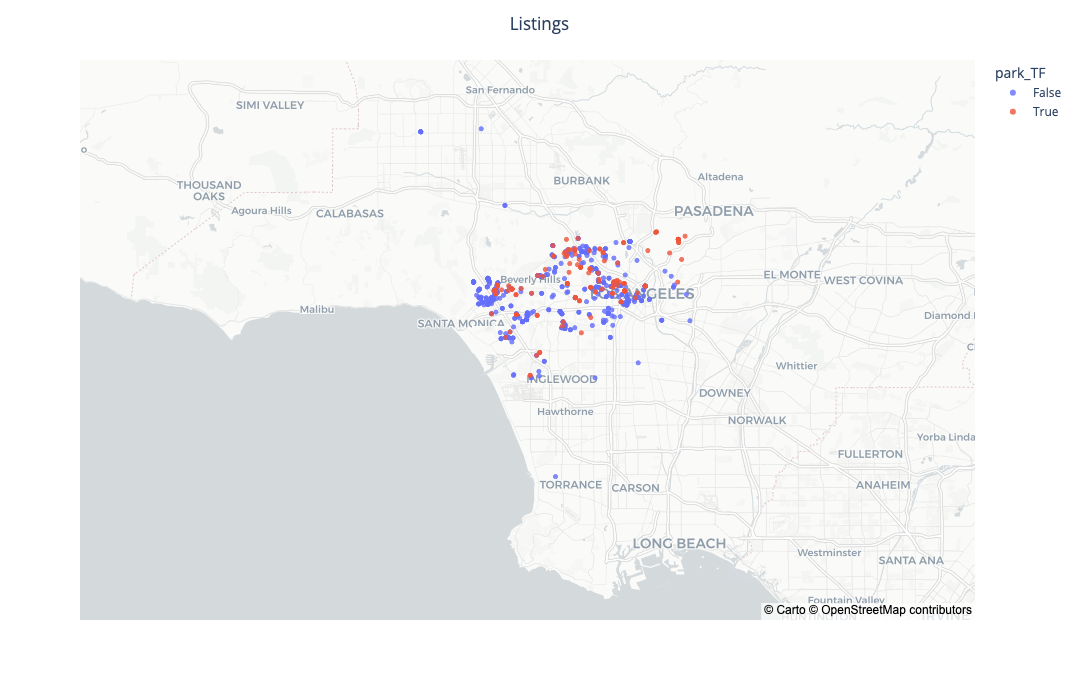

In [59]:
# import libraries
import plotly.express as px
import matplotlib.pyplot as plt


# create scatter map
fig = px.scatter_mapbox(test, lat=test.geometry.y, lon=test.geometry.x, color="park_TF",
                               mapbox_style="carto-positron",
                               #range_color=range_color,
                               zoom=9,
                               center = {"lat": 34, "lon": -118.4},
                               opacity=.8,

                               )

# options on the layout
fig.update_layout(
        width = 900,
        height = 700,
        title = "Listings",
        title_x = .5
    )
fig.show()

In [19]:
listingsDf_trim.to_pickle("./dummy.pkl")